# Modelling

In [158]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
import pickle
from sklearn import clone

import pyarrow as pa

from imblearn.over_sampling import SMOTE

We start by importing all the tools we'll need for this classification challenge. Since we're dealing with recidivism prediction (a binary classification problem), we bring in multiple algorithms to compare from simple logistic regression to complex ensemble methods. Importantly, we include `SMOTE` because we will purposefully undersample our dataset so that it has class imbalance, and we'll need to handle that carefully to avoid biased predictions.

## Load the Processed Data

In [159]:
# Ensure pyarrow is available and use it as the parquet engine to avoid ArrowKeyError
df_encoded = pd.read_parquet('../data/processed/compas_processed.parquet', engine='fastparquet')
df_encoded.head()

,juv_fel_count,juv_misd_count,priors_count,days_b_screening_arrest,is_recid,jail_days,c_charge_degree_M,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,age_cat_Greater than 45,age_cat_Less than 25,sex_Male,total_juv_offenses,has_juv_record,young_with_priors
0,0,0,0,0.0,0,0,0,0,0,0,0,1,1,0,1,0,0,0
1,0,0,0,0.0,1,10,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,4,0.0,1,1,0,0,0,0,0,0,0,1,1,0,0,1
3,0,0,0,0.0,0,1,1,0,0,0,0,1,0,0,1,0,0,0
4,0,0,14,0.0,1,6,0,0,1,0,0,0,0,0,1,0,0,0


Loading the processed dataset that we prepared in the EDA notebook. This data already has our engineered features (like `criminal_severity` and `priors_category`) and all categorical variables are one-hot encoded. By using the parquet format, we get fast loading and preserve data types. Let's verify the structure looks correct before proceeding.

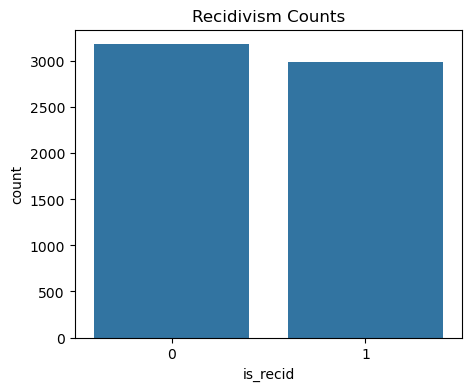

In [160]:
plt.figure(figsize=(5,4))
sns.countplot(x='is_recid', data=df_encoded)
plt.ylabel('count')
plt.xlabel('is_recid')
plt.title('Recidivism Counts')
plt.show()

Here we can see that the class 0 and class 1 is balanced

## Simulate Undersampling of the Recidivists Group to Artificially Achieve Imbalance

In [161]:
positive = df_encoded[df_encoded["is_recid"] == 1]      # recidivists
negative = df_encoded[df_encoded["is_recid"] == 0]      # non-recidivists

positive_small = positive.sample(frac=0.20, random_state=42)

df_imbalanced = pd.concat([positive_small, negative], axis=0).sample(frac=1)
df_imbalanced["is_recid"].value_counts()

is_recid
0    3182
1     598
Name: count, dtype: int64

To simulate a more challenging real-world scenario and rigorously test our imbalance handling techniques, I'm artificially creating a stronger class imbalance. By undersampling the recidivist class to just 20% of its original size, we'll have far fewer positive examples. This will force our SMOTE implementation and class weighting strategies to work harder if they perform well here, they'll definitely handle the original imbalance.

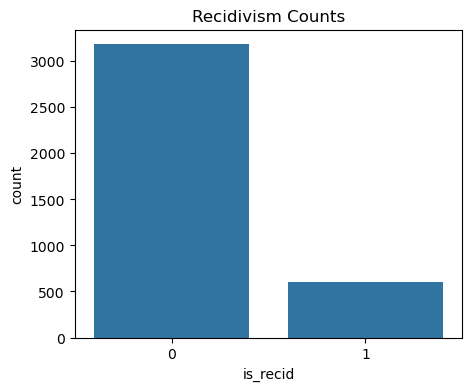

In [162]:
plt.figure(figsize=(5,4))
sns.countplot(x='is_recid', data=df_imbalanced)
plt.ylabel('count')
plt.xlabel('is_recid')
plt.title('Recidivism Counts')
plt.show()

Visualizing the new imbalance confirms we have a significant disparity—the minority class (recidivists) is now heavily outnumbered. This is intentional and realistic: in many criminal justice applications, recidivism rates can be relatively low, making the prediction task more difficult but also more important to get right. Now we're ready to split the data and build our modeling pipeline.

In [163]:
X = df_imbalanced.drop("is_recid", axis=1)
y = df_imbalanced["is_recid"]
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=100)

print(X_train.columns)

(3780, 17) (3780,)
Index(['juv_fel_count', 'juv_misd_count', 'priors_count',
       'days_b_screening_arrest', 'jail_days', 'c_charge_degree_M',
       'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American',
       'race_Other', 'age_cat_Greater than 45', 'age_cat_Less than 25',
       'sex_Male', 'total_juv_offenses', 'has_juv_record',
       'young_with_priors'],
      dtype='object')


Now we separate features from the target and create our train-test split. Using stratification is crucial here, it ensures both our training and test sets maintain the same class imbalance ratio, preventing any data leakage and ensuring fair evaluation. The 80-20 split gives us enough data to train complex models while reserving sufficient samples for testing. Let's also check what features we're working with.

In [164]:
scale_feats = ["juv_fel_count", "juv_misd_count", "priors_count", "jail_days"]

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), scale_feats),
    ],
    remainder='passthrough'
)

Some of our features (like `priors_count` and `jail_days`) are on very different scales than our binary one-hot encoded features. Distance-based algorithms like SVM and KNN are sensitive to these scale differences, so we need to standardize them. I'm using a ColumnTransformer to selectively scale only the continuous features while leaving the binary features as-is. This preprocessing will be embedded in our pipeline to prevent data leakage.

## Batch Definition of Classification Models

In [165]:
stacking_estimators = [
    ('svm_rbf', SVC(kernel='rbf', class_weight='balanced', probability=True)),
    ('logreg', LogisticRegression(class_weight='balanced')),
    ('knn', KNeighborsClassifier())
]


models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", random_state=100),
    "SVM Linear": SVC(kernel='linear', random_state=100, class_weight="balanced"),
    "SVM RBF": SVC(kernel='rbf', random_state=100, class_weight="balanced"),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", random_state=100),
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=100),
    "Extra Trees": ExtraTreesClassifier(class_weight="balanced", random_state=100),
    "Gradient Boosting": GradientBoostingClassifier(random_state=100),
    "lightGBM": LGBMClassifier(class_weight="balanced", random_state=100, verbose=-1),
    "xgboost": XGBClassifier(scale_pos_weight= (y_train == 0).sum() / (y_train == 1).sum(), random_state=100, verbose=0),     
    "catboost": CatBoostClassifier(class_weights=[1, (y_train == 0).sum() / (y_train == 1).sum()], random_state=100, verbose=0),
    "stacking": StackingClassifier(
        estimators=stacking_estimators,
        final_estimator=LogisticRegression(random_state=100)
    )
}

Instead of committing to one algorithm upfront, I'm defining a diverse set of 12 classifiers. From simple linear models to complex ensembles. Each model is configured with class imbalance handling: most use `class_weight='balanced'` which automatically adjusts weights inversely proportional to class frequencies. XGBoost and CatBoost have their own syntax for this. The stacking classifier is interesting, it combines predictions from multiple strong learners (SVM, LogReg, KNN) to potentially capture different aspects of the data. Now we'll see which approach works best for our recidivism prediction task.

In [166]:
params = {
    "Logistic Regression": {
        'model__C': [0.01, 0.1, 1, 10, 100]
    },
    "SVM Linear": { 
        'model__C': [0.01, 0.1, 1, 10, 100]
    },
    "SVM RBF": {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__gamma': ['scale', 'auto']
    },
    "K-Nearest Neighbors": {
        'model__n_neighbors': [3, 5, 7, 9]
    },
    "Decision Tree": {
        'model__max_depth': [None, 5, 10, 15],
        'model__min_samples_split': [2, 5, 10]
    },
    "Random Forest": {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 5, 10],
        'model__min_samples_split': [2, 5, 10]
    },
        "Extra Trees": {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 5, 10],
        'model__min_samples_split': [2, 5, 10]
    },
    "Gradient Boosting": {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    "lightGBM": {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    "xgboost": {
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    "catboost": {
        'model__iterations': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__depth': [3, 5, 7]
    },
    "stacking": {
        'model__final_estimator__C': [0.01, 0.1, 1, 10, 100]
    }
}


for model_name, estimator in models.items():
    pipe = Pipeline(steps=[
        ('smote', SMOTE(random_state=42)),
        ('preprocess', clone(preprocess)),
        ('model', estimator)
    ])

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=params[model_name],
        cv=5,
        scoring='f1',
        n_jobs=-1,
    )

    gs.fit(X_train, y_train)
    pickle.dump(gs, open(f'../models/{model_name}_gridsearch.pkl', 'wb'))


/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifi

Here's where the magic happens. For each model, I'm creating a complete Pipeline: SMOTE first (to generate synthetic minority class samples), then preprocessing (to scale features), then the model itself. This order is critical, SMOTE only sees training data within each CV fold, preventing data leakage. We use GridSearchCV to systematically test different hyperparameters with 5-fold cross-validation, optimizing for F1 score (which balances precision and recall—important for imbalanced data). Each optimized model gets saved so we can load them later without retraining. This will take several minutes since we're training 12 models with multiple hyperparameter combinations each.

In [167]:
models = {}
results = {}
pipelines = {}

folder = "../models"

# Load all models from folder
for file in os.listdir(folder):
    if file.endswith(".pkl"):
        model_name = file.replace(".pkl", "") 
        with open(os.path.join(folder, file), "rb") as f:
            models[model_name] = pickle.load(f)

for model_name, gs in models.items():
    best_model = gs.best_estimator_ if hasattr(gs, "best_estimator_") else gs
    
    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results[model_name] = report
    pipelines[model_name] = best_model

/opt/miniconda3/envs/portfolio/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Now that all models are trained and saved, let's load them back and evaluate their performance on our held-out test set. For each model, we extract the best estimator found by GridSearch, make predictions, and generate a detailed classification report with precision, recall, and F1 scores for both classes. By storing everything in dictionaries, we can easily compare all 12 models side-by-side in the next steps. This is the moment of truth, which approach best predicts recidivism?

In [168]:
rows = []
for model_name, report in results.items():
    for label, metrics in report.items():
        if label in ["0", "1"]:
            rows.append({
                "model": model_name,
                "class": label,
                "precision": metrics["precision"],
                "recall": metrics["recall"],
                "f1": metrics["f1-score"],
                "support": metrics["support"],
            })

result_df = pd.DataFrame(rows)

result_df_minor = result_df[result_df["class"] == "1"] \
    .sort_values("recall", ascending=False)

result_df_minor

,model,class,precision,recall,f1,support
23,catboost_gridsearch,1,0.186644,0.908333,0.309659,120.0
17,xgboost_gridsearch,1,0.185512,0.875000,0.306122,120.0
15,SVM Linear_gridsearch,1,0.212121,0.641667,0.318841,120.0
9,Random Forest_gridsearch,1,0.270270,0.583333,0.369393,120.0
3,SVM RBF_gridsearch,1,0.308036,0.575000,0.401163,120.0
11,Logistic Regression_gridsearch,1,0.259398,0.575000,0.357513,120.0
13,stacking_gridsearch,1,0.283186,0.533333,0.369942,120.0
1,Decision Tree_gridsearch,1,0.209302,0.525000,0.299287,120.0
5,Gradient Boosting_gridsearch,1,0.300971,0.516667,0.380368,120.0
21,Extra Trees_gridsearch,1,0.241245,0.516667,0.328912,120.0


Let's structure the results for easy comparison. I'm focusing on the minority class (recidivists, class 1) because correctly identifying potential recidivists is more critical than identifying non-recidivists, the cost of missing a recidivist (false negative) is typically higher in criminal justice applications. Sorting by recall shows us which models are best at catching recidivism cases, even if it means some false alarms. This table will help us quickly identify our top performers.

/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_5262/2436557067.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=result_df_minor, x="model", y="recall", palette="viridis", ax=axes[0])
/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_5262/2436557067.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_by_precision, x="model", y="precision", palette="viridis", ax=axes[1])
/var/folders/n1/k6wd8lyx2b76lr9n8ln2vjch0000gn/T/ipykernel_5262/2436557067.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=

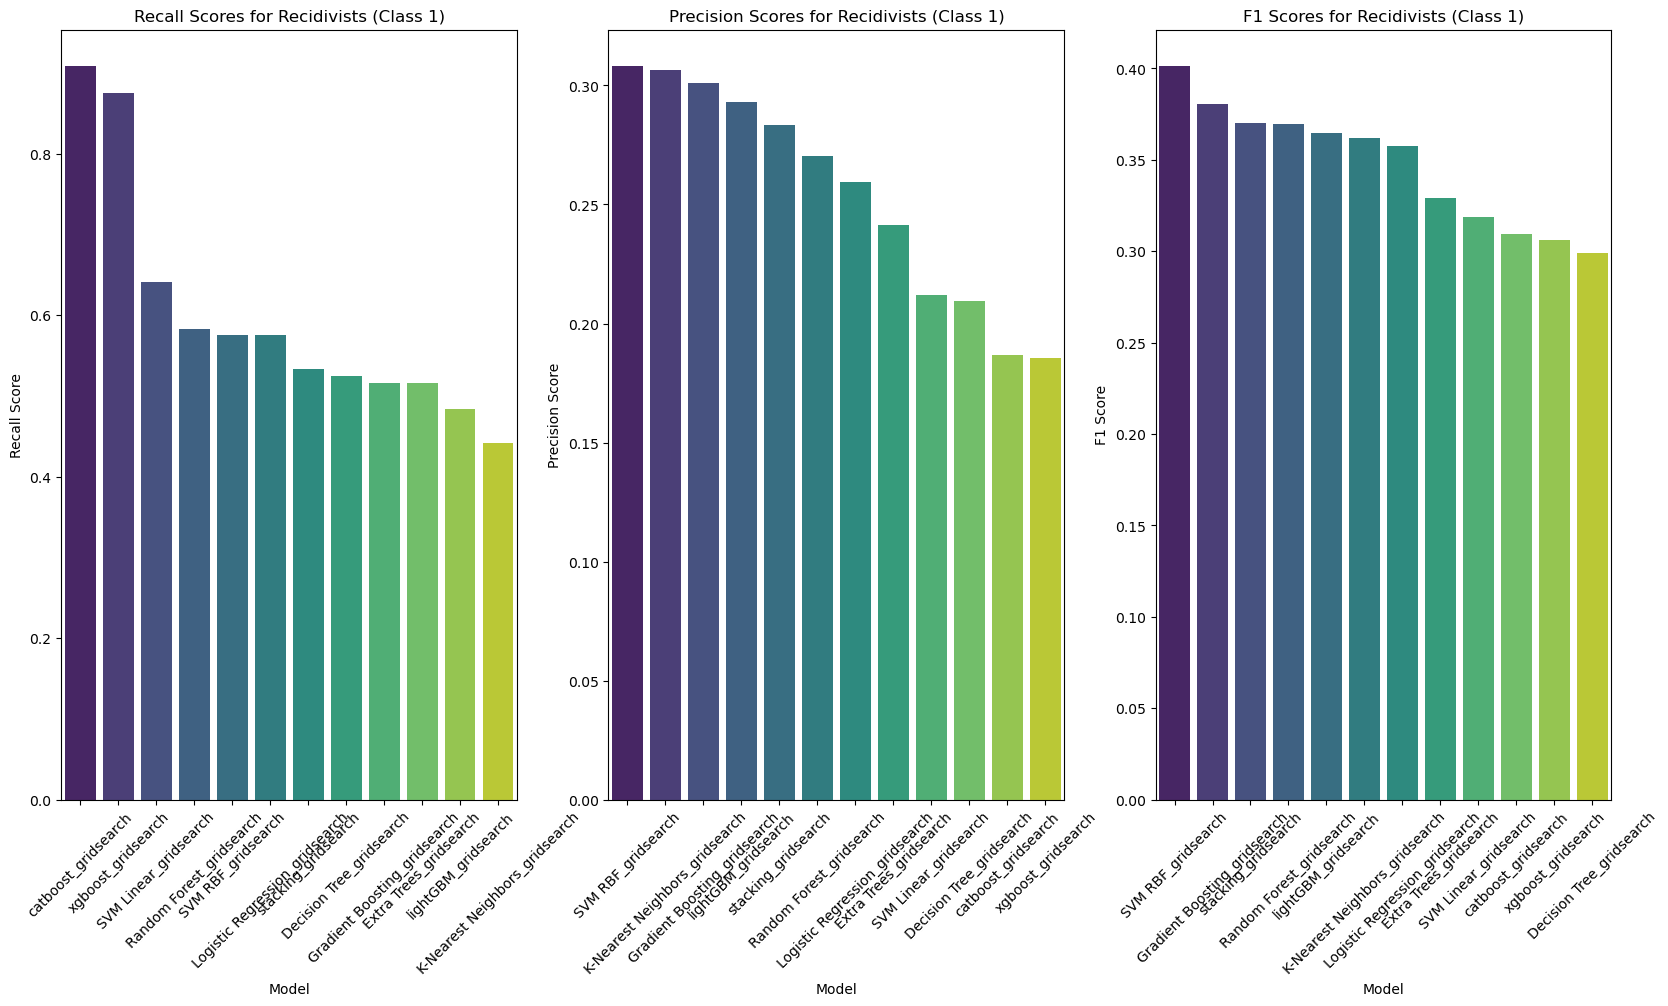

In [169]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))


sns.barplot(data=result_df_minor, x="model", y="recall", palette="viridis", ax=axes[0])
axes[0].set_title("Recall Scores for Recidivists (Class 1)")
axes[0].set_ylabel("Recall Score")
axes[0].set_xlabel("Model")
axes[0].tick_params(axis='x', rotation=45)

sorted_by_precision = result_df_minor.sort_values("precision", ascending=False)
sns.barplot(data=sorted_by_precision, x="model", y="precision", palette="viridis", ax=axes[1])
axes[1].set_title("Precision Scores for Recidivists (Class 1)")
axes[1].set_ylabel("Precision Score")
axes[1].set_xlabel("Model")
axes[1].tick_params(axis='x', rotation=45)

sorted_by_f1 = result_df_minor.sort_values("f1", ascending=False)
sns.barplot(data=sorted_by_f1, x="model", y="f1", palette="viridis", ax=axes[2])
axes[2].set_title("F1 Scores for Recidivists (Class 1)")
axes[2].set_ylabel("F1 Score")
axes[2].set_xlabel("Model")
axes[2].tick_params(axis='x', rotation=45)
plt.show()

The model comparison shows clear trade-offs between recall, precision, and overall F1 performance for predicting recidivism. CatBoost achieves the highest recall and F1, meaning it catches the most true reoffenders, but it does so by heavily overpredicting recidivism, resulting in very low precision and many false positives. In contrast, SVM RBF delivers the best precision with still-reasonable recall, making it the most balanced and fairness-aligned model—it avoids unnecessarily flagging low-risk individuals while maintaining solid predictive power. Logistic Regression also performs consistently and serves as a strong, interpretable baseline. Overall, if the priority is maximizing public safety through high recall, CatBoost is best, but if fairness, balance, and minimizing false accusations matter, SVM RBF is the more appropriate choice.